<a href="https://colab.research.google.com/github/Smart-Pigs/Depth-Images/blob/main/Weight_Estimation_Image_Descriptors_Cropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have this folder as shortcut in your drive - /content/gdrive/MyDrive/Morota-video-data/ 

In [ ]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Data Loading

In [ ]:
#@markdown Select resolution of input dataset and weeks of data

Instantiate_New_Dataset = True #@param {type:"boolean"}
Refresh_Old_Dataset = False #@param {type:"boolean"}

Dataset = "CROPPED"  #@param ['CROPPED', 'SQUARE']

if Instantiate_New_Dataset == True:
  !rm -rf Week*/

Resolution = "256"  #@param ['512', '256']

Resolution_Segmentation = "256"  #@param ['720','288', '256']

if Refresh_Old_Dataset == False:
  if Resolution == "512":
    if Dataset == "CROPPED":
      !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_512.zip .
      !unzip -qq CROPPED_WEEK1-10_512.zip -d .
    if Dataset == "SQUARE":
      !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/SQUARE/SQUARE_WEEK1-10_512.zip .
      !unzip -qq SQUARE_WEEK1-10_512.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "256":
    if Dataset == "CROPPED":
      !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_256.zip .
      !unzip -qq CROPPED_WEEK1-10_256.zip -d .
    if Dataset == "SQUARE":
      !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/SQUARE/SQUARE_WEEK1-10_256.zip .
      !unzip -qq SQUARE_WEEK1-10_256.zip -d .
    !rm -rf *WEEK*.zip

if Resolution_Segmentation == "720" and Dataset == "CROPPED":
  !cp /content/gdrive/MyDrive/Morota-video-data/SEGMENTED_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_720_masks.zip .
  !unzip -qq CROPPED_WEEK1-10_720_masks.zip -d .
  !rm -rf *WEEK*.zip
if Resolution_Segmentation == "288" and Dataset == "CROPPED":
  !cp /content/gdrive/MyDrive/Morota-video-data/SEGMENTED_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_288_masks.zip .
  !unzip -qq CROPPED_WEEK1-10_288_masks.zip -d .
  !rm -rf *WEEK*.zip
if Resolution_Segmentation == "256" and Dataset == "CROPPED":
  !cp /content/gdrive/MyDrive/Morota-video-data/SEGMENTED_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_256_masks.zip .
  !unzip -qq CROPPED_WEEK1-10_256_masks.zip -d .
  !rm -rf *WEEK*.zip
if Dataset == "SQUARE":
  Resolution_Segmentation = "512"
  !cp /content/gdrive/MyDrive/Morota-video-data/SEGMENTED_INDIVIDUAL/SQUARE/SQUARE_WEEK1-10_512_masks.zip .
  !unzip -qq SQUARE_WEEK1-10_512_masks.zip -d .
  !rm -rf *WEEK*.zip

### Mapping Table Input

In [ ]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt


final_map = pd.read_csv("/content/gdrive/MyDrive/Morota-video-data/final_mapping.csv")
weeks = final_map
weeks

,Unnamed: 0,image_path,Date,Pig,weight,Week,pig_on_edge
0,0,Week1/20210922/20210922_3330_b/_Depth_4683.jpg,20210922,3330,15.5,1,0
1,21,Week1/20210922/20210922_3330_b/_Depth_4682.jpg,20210922,3330,15.5,1,0
2,22,Week1/20210922/20210922_3330_b/_Depth_4625.jpg,20210922,3330,15.5,1,0
3,35,Week1/20210922/20210922_3330_b/_Depth_4704.jpg,20210922,3330,15.5,1,0
4,38,Week1/20210922/20210922_3330_b/_Depth_4855.jpg,20210922,3330,15.5,1,0
...,...,...,...,...,...,...,...
36587,96209,Week10/20211119/20211119_3342/_Depth_3044.jpg,20211119,3342,56.6,10,0
36588,96210,Week10/20211119/20211119_3342/_Depth_2546.jpg,20211119,3342,56.6,10,0
36589,96214,Week10/20211119/20211119_3342/_Depth_2741.jpg,20211119,3342,56.6,10,0
36590,96217,Week10/20211119/20211119_3342/_Depth_2754.jpg,20211119,3342,56.6,10,0


In [ ]:
folder = '/content/CROPPED_WEEK1-10_256_masks/'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def threshold_image(segmented_image, threshold=128):
    _, binary_image = cv2.threshold(segmented_image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def create_masked_depth_image(depth_image, binary_image):
    masked_depth_image = cv2.cvtColor(depth_image, cv2.COLOR_GRAY2RGB)
    #masked_depth_image[binary_image == 0] = 0
    return masked_depth_image

def mark_points_and_labels(ax, bounding_box, width, length):
    p1, p2, p3, _ = bounding_box
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], marker='o', markersize=5, color='r')
    ax.plot([p2[0], p3[0]], [p2[1], p3[1]], marker='o', markersize=5, color='r')
    
    ax.text((p1[0]+p2[0])/2, (p1[1]+p2[1])/2, f'W: {width}', color='w', fontsize=12)
    ax.text((p2[0]+p3[0])/2, (p2[1]+p3[1])/2, f'L: {length}', color='w', fontsize=12)

def mark_center_and_height(ax, bounding_box, height):
    center = np.mean(bounding_box, axis=0).astype(int)
    ax.plot(center[0], center[1], marker='o', markersize=5, color='w')
    ax.text(center[0] + 5, center[1] + 5, f'H: {height}', color='w', fontsize=12)

def find_bounding_box(segmented_image):
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    bounding_box = None
    selected_contour = None

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            bounding_box = np.int0(box)
            selected_contour = cnt

    return bounding_box, selected_contour

def compute_dimensions(bounding_box):
    p1, p2, p3, _ = bounding_box

    width = int(np.linalg.norm(p1 - p2))
    length = int(np.linalg.norm(p2 - p3))

    return width, length

def compute_height(depth_image, bounding_box):
    center = np.mean(bounding_box, axis=0).astype(int)
    height = depth_image[center[1], center[0]]

    return height

def visualize_pig_measurements(masked_depth_image, bounding_box, selected_contour, width, length, height):
    fig, ax = plt.subplots(1)
    ax.imshow(masked_depth_image)

    for i in range(4):
        p1 = bounding_box[i]
        p2 = bounding_box[(i+1) % 4]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='g', linewidth=2)

    plt.plot(selected_contour[:, 0, 0], selected_contour[:, 0, 1], color='b', linewidth=1)
    mark_points_and_labels(ax, bounding_box, width, length)
    mark_center_and_height(ax, bounding_box, height)

    plt.show()

def estimate_pig_weight(segmented_image_path, depth_image_path):
    segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
    depth_image = cv2.imread(depth_image_path, cv2.IMREAD_GRAYSCALE)
    binary_image = threshold_image(segmented_image)
    masked_depth_image = create_masked_depth_image(depth_image, binary_image)

    bounding_box, selected_contour = find_bounding_box(binary_image)
    if bounding_box is None:
      print("No suitable bounding box found")
      return 0, 0, 0
    width, length = compute_dimensions(bounding_box)
    height = compute_height(depth_image, bounding_box)

    visualize_pig_measurements(masked_depth_image, bounding_box, selected_contour, width, length, height)
    print("Width : ", width)
    print("Length : ", length)
    print("Height : ", height)
    return width, length, height

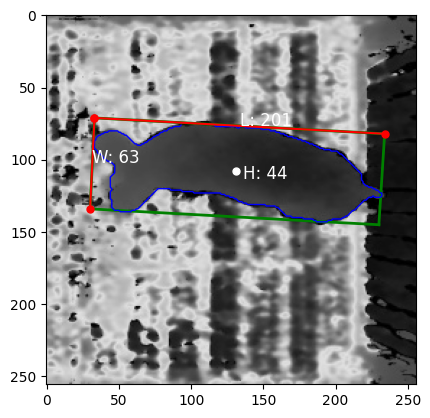

Width :  63
Length :  201
Height :  44


In [ ]:
depth_img = weeks.sample(1).iloc[0].tolist()[0]
seg_img = folder + depth_img
W, L, H = estimate_pig_weight(seg_img, depth_img)

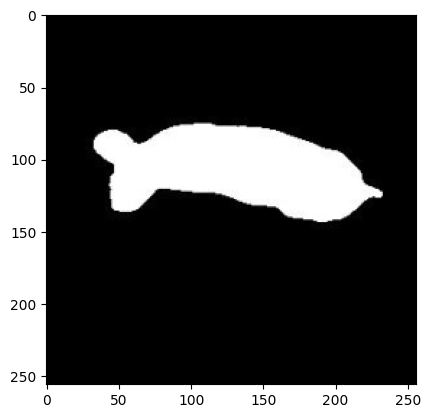

In [ ]:
seg = cv2.imread(seg_img,cv2.IMREAD_GRAYSCALE)
plt.imshow(seg,cmap='gray')

In [ ]:
weeks['width']=0
weeks['length']=0
weeks['height']=0

In [ ]:
weeks = weeks.drop('Unnamed: 0',axis=1)

In [ ]:
weeks

,image_path,Date,Pig,weight,Week,pig_on_edge,width,length,height
0,Week1/20210922/20210922_3330_b/_Depth_4683.jpg,20210922,3330,15.5,1,0,0,0,0
1,Week1/20210922/20210922_3330_b/_Depth_4682.jpg,20210922,3330,15.5,1,0,0,0,0
2,Week1/20210922/20210922_3330_b/_Depth_4625.jpg,20210922,3330,15.5,1,0,0,0,0
3,Week1/20210922/20210922_3330_b/_Depth_4704.jpg,20210922,3330,15.5,1,0,0,0,0
4,Week1/20210922/20210922_3330_b/_Depth_4855.jpg,20210922,3330,15.5,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
36587,Week10/20211119/20211119_3342/_Depth_3044.jpg,20211119,3342,56.6,10,0,0,0,0
36588,Week10/20211119/20211119_3342/_Depth_2546.jpg,20211119,3342,56.6,10,0,0,0,0
36589,Week10/20211119/20211119_3342/_Depth_2741.jpg,20211119,3342,56.6,10,0,0,0,0
36590,Week10/20211119/20211119_3342/_Depth_2754.jpg,20211119,3342,56.6,10,0,0,0,0


In [ ]:
# Iterate through the entire DataFrame
for index, row in weeks.iterrows():
    depth_img = row['image_path']
    seg_img = folder + depth_img
    print(f"Processing image: {depth_img}")
    W, L, H = estimate_pig_weight(seg_img, depth_img)
    weeks.at[index, 'width'] = W
    weeks.at[index, 'length'] = L
    weeks.at[index, 'height'] = H
    #if W == 0 and L == 0 and H ==0:
    #  weeks.at[index, 'pig_on_edge']=1

Streaming output truncated to the last 5000 lines.
Length :  76
Height :  37
Processing image: Week10/20211119/20211119_3384/_Depth_12153.jpg
Width :  53
Length :  161
Height :  30
Processing image: Week10/20211119/20211119_3384/_Depth_11855.jpg
Width :  79
Length :  216
Height :  63
Processing image: Week10/20211119/20211119_3384/_Depth_11672.jpg
Width :  201
Length :  76
Height :  54
Processing image: Week10/20211119/20211119_3384/_Depth_12146.jpg
Width :  53
Length :  204
Height :  37
Processing image: Week10/20211119/20211119_3384/_Depth_11429.jpg
Width :  76
Length :  215
Height :  43
Processing image: Week10/20211119/20211119_3384/_Depth_12193.jpg
Width :  57
Length :  162
Height :  30
Processing image: Week10/20211119/20211119_3384/_Depth_11681.jpg
Width :  187
Length :  83
Height :  54
Processing image: Week10/20211119/20211119_3384/_Depth_11376.jpg
Width :  162
Length :  106
Height :  62
Processing image: Week10/20211119/20211119_3384/_Depth_11313.jpg
Width :  211
Length :  65

In [ ]:
weeks

,image_path,Date,Pig,weight,Week,pig_on_edge,width,length,height,height_adjusted
0,Week1/20210922/20210922_3330_b/_Depth_4683.jpg,20210922,3330,15.5,1,0,42,105,36,219
1,Week1/20210922/20210922_3330_b/_Depth_4682.jpg,20210922,3330,15.5,1,0,44,115,36,219
2,Week1/20210922/20210922_3330_b/_Depth_4625.jpg,20210922,3330,15.5,1,0,59,169,38,217
3,Week1/20210922/20210922_3330_b/_Depth_4704.jpg,20210922,3330,15.5,1,0,1,1,47,208
4,Week1/20210922/20210922_3330_b/_Depth_4855.jpg,20210922,3330,15.5,1,0,148,70,33,222
...,...,...,...,...,...,...,...,...,...,...
36587,Week10/20211119/20211119_3342/_Depth_3044.jpg,20211119,3342,56.6,10,0,5,12,60,195
36588,Week10/20211119/20211119_3342/_Depth_2546.jpg,20211119,3342,56.6,10,0,193,82,49,206
36589,Week10/20211119/20211119_3342/_Depth_2741.jpg,20211119,3342,56.6,10,0,76,233,52,203
36590,Week10/20211119/20211119_3342/_Depth_2754.jpg,20211119,3342,56.6,10,0,205,67,42,213


In [ ]:
weeks.to_csv('final_mapping_descriptors.csv',index=False)